In [1]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
from unsloth import unsloth_train
from unsloth.chat_templates import train_on_responses_only

from datasets import Dataset
from vllm import SamplingParams
from transformers import TrainingArguments, TrainerCallback
from transformers import TextStreamer
from trl import SFTTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-10 13:18:01 __init__.py:190] Automatically detected platform cuda.


In [2]:
import random
import json
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval

from sampling.sampling_fallacies_detection import load_all_dataset, get_prt, get_all_spl

In [3]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
paths = {
    'cocolofa': './Data_jsonl/cocolofa.jsonl',
    'mafalda': './Data_jsonl/mafalda.jsonl'
}
SYSTEM_PROMPT = 'You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>.'
n_sample = 4000
e = 1.5
n_eval = 8
n_eval_step = np.floor((n_sample / 32) / n_eval)

model_name = 'Llama3.18BInstruct'
spl_name = 'spl2'
task_name = 'fallacies'
train_resp = '_train_resp'

train_spl_file = f'./sampling/sample/{task_name}/{spl_name}_train.csv'
val_spl_file = f'./sampling/sample/{task_name}/{spl_name}_val.csv'
test_spl_file = f'./sampling/sample/{task_name}/{spl_name}_test.csv'

outputs_dir = f'./outputs/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}'

test_result_file = f'./test_res/{task_name}/test_res_{model_name}_{e}e{n_sample}{spl_name}{train_resp}.csv'
result_file = f'./test_res/{task_name}/test_res_{model_name}_{e}e{n_sample}{spl_name}{train_resp}.csv'

file_stat_train = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_train.png'
file_stat_val = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_val.png'
file_stat_test = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_test.png'

file_plot_single = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_res_single.png'
file_plot_multi = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_res_multi.png'

file_metric_single = f'./test_res/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_metric_single.csv'
file_metric_multi = f'./test_res/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_metric_multi.csv'

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name= "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    fast_inference=True,
    gpu_memory_utilization=0.6
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.50.0. vLLM: 0.7.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.451 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.58%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 44.45 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 288.
Unsloth: vLLM's KV Cache can use up to 20.15 GB. Also swap space = 6 GB.
INFO 04-10 13:19:34 config.py:542] This model supports multiple tasks: {'score', 'reward', 'generate', 'embed', 'classify'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes conf

[W410 13:19:36.908814310 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 04-10 13:19:37 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 04-10 13:19:37 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-10 13:20:21 model_runner.py:1115] Loading model weights took 5.5976 GB
INFO 04-10 13:20:21 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 04-10 13:20:26 worker.py:267] Memory profiling takes 4.07 seconds
INFO 04-10 13:20:26 worker.py:267] the current vLLM instance can use total_gpu_memory (44.45GiB) x gpu_memory_utilization (0.60) = 26.48GiB
INFO 04-10 13:20:26 worker.py:267] model weights take 5.60GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.35GiB; the rest of the memory reserved for KV Cache is 19.48GiB.
INFO 04-10 13:20:26 executor_base.py:110] # CUDA blocks: 9974, # CPU blocks: 3072
INFO 04-10 13:20:26 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 77.92x
INFO 04-10 13:20:38 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 39/39 [01:45<00:00,  2.71s/it]

INFO 04-10 13:22:24 model_runner.py:1562] Graph capturing finished in 106 secs, took 0.87 GiB
INFO 04-10 13:22:24 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 122.80 seconds



Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
data, fallacies = load_all_dataset(paths)
# spl_data = get_all_spl(data, fallacies, n_sample)
# prt_train, prt_val, prt_test = get_prt(spl_data, fallacies, SYSTEM_PROMPT)

# prt_train.to_csv(train_spl_file, index=False)
# prt_val.to_csv(val_spl_file, index=False)
# prt_test.to_csv(test_spl_file, index=False)


In [6]:
converter = {'prompt': literal_eval, 'answer': literal_eval}
prt_train = pd.read_csv(
    train_spl_file,
    converters=converter
)
prt_val = pd.read_csv(
    val_spl_file,
    converters=converter
)
prt_test = pd.read_csv(
    test_spl_file,
    converters=converter
)

In [7]:
def formatting_prompt(data: dict):
    text = tokenizer.apply_chat_template(data.get('prompt'),tokenize = False, add_generation_prompt = False)
    return { 'text': text, }

SAMPLING_PARAMS = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 128,
)
data_train = Dataset.from_pandas(prt_train).map(
    formatting_prompt,
    batched=True,
)
data_val = Dataset.from_pandas(prt_val).map(
    formatting_prompt,
    batched=True,
)
data_test = Dataset.from_pandas(prt_test).map(
    formatting_prompt,
    batched=True
).shuffle(seed=0)

Map:   0%|          | 0/5453 [00:00<?, ? examples/s]

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1206 [00:00<?, ? examples/s]

In [ ]:
# def gen(txt, model, sampling_params):
#     output = model.fast_generate(
#         txt,
#         sampling_params = sampling_params,
#     )[0].outputs[0].text
    
#     return output

# def format_output(answer: str, fallacies: set) -> list:
#     s = '<[|]ANSWER[|]>'
#     tmp = re.split(s, answer)
#     pred= [i for i in tmp if i in fallacies]
#     return pred

# def zero_shot_gen(data: list[str], model, fallacies: set, sampling_params) -> list:
#     res = []
#     for i in data:
#         out = gen(i, model, sampling_params)
#         pred = format_output(out, fallacies)
#         res.append(pred)
#     return res

In [8]:
def gen(p, model, text_streamer):
    txt = tokenizer.apply_chat_template(
        p,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to('cuda')
    output = model.generate(
        txt,
        streamer=text_streamer,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id
    )
    return output

def format_output(answer: list, labels: set) -> list:
    s = '<[|]ANSWER[|]>'
    tmp = re.split(s, answer[0])
    pred = [i for i in tmp if i in labels]
    return pred

def zero_shot_gen(
    data:Dataset,
    model,
    labels:set,
    text_streamer: TextStreamer
) -> list:
    res= []
    prompt = data['prompt']
    for prt in prompt:
        out = gen(prt, model, text_streamer)
        decoded_out = tokenizer.batch_decode(out)
        pred = format_output(decoded_out, labels)
        res.append(pred)
    return res

In [ ]:
# class custom_validation_callback(TrainerCallback):
#     def __init__(self, data, sampling_params, fallacies, n_step=10):
#         super().__init__()
#         self.val_dataset = data
#         self.sampling_params = sampling_params
#         self.fallacies = fallacies
#         self.n_step=n_step
#     def on_step_end(self, args, state, control, **kwargs):
#         if state.global_step % self.n_step == 0 and state.global_step > 0 :
#             model.save_lora('sft_save_lora')
#             FastLanguageModel.for_inference(model)
#             pred = zero_shot_gen(
#                 data=self.val_dataset['text'],
#                 model=model,
#                 fallacies=self.fallacies,
#                 sampling_params=self.sampling_params
#             )
#             tmp_pred = [i if i != [] else ['Failed'] for i in pred]
#             d = pd.DataFrame().from_records(tmp_pred)
#             d['truth_label'] = self.val_dataset['answer']
#             d['step'] = np.full((len(d['truth_label']),), state.global_step)
#             try:
#                 d.to_csv(
#                     './validation_res.csv',
#                     index=False,
#                     mode='a',
#                     header=['pred', 'truth_label', 'step']
#                 )
#             except FileNotFoundError:
#                 d.to_csv('./validation_res.csv', index=False, header=['pred', 'truth_label'])
#         return super().on_step_end(args, state, control, **kwargs)

# class custom_test_callback(TrainerCallback):
#     def __init__(self, data, sampling_params, fallacies):
#         super().__init__()
#         self.test_dataset = data
#         self.sampling_params = sampling_params
#         self.fallacies = fallacies
#     def on_train_end(self, args, state, control, **kwargs):
#         model.save_lora('sft_save_lora')
#         FastLanguageModel.for_inference(model)
#         pred = zero_shot_gen(
#             data=self.test_dataset['text'],
#             model=model,
#             fallacies=self.fallacies,
#             sampling_params=self.sampling_params
#         )
#         tmp_pred = [i if i != [] else ['Failed'] for i in pred]
#         d = pd.DataFrame().from_records(tmp_pred)
#         d['truth_label'] = self.test_dataset['answer']
#         try:
#             d.to_csv('./test_res.csv', index=False, mode='a', header=['pred','truth_label'])
#         except FileNotFoundError:
#             d.to_csv('./test_res.csv', index=False, header=['pred', 'truth_label'])
#         return super().on_train_end(args, state, control, **kwargs)

In [9]:
training_args = TrainingArguments(
    per_device_train_batch_size = 4, #2
    per_device_eval_batch_size= 4,
    gradient_accumulation_steps = 8, #4
    eval_accumulation_steps= 8,
    warmup_steps = 5,
    num_train_epochs = e, # Set this for 1 full training run.
    # max_steps = 60,
    learning_rate = 2e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = outputs_dir,
    report_to = "tensorboard", # Use this for WandB etc
    eval_strategy="steps",
    eval_steps=n_eval_step,
)   
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = data_train,
    eval_dataset=data_val,
    # formatting_func=formatting_prompt,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args,
)
# trainer.get_train_dataloader().shuffle = False
# trainer.get_eval_dataloader().shuffle = False
# trainer.train()
if train_resp == '_train_resp':
    trainer = train_on_responses_only(
        trainer,
        instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",
        response_part="<|start_header_id|>assistant<|end_header_id|>\n\n"
    )
unsloth_train(trainer)

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/5453 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1180 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/5453 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/1180 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,453 | Num Epochs = 2 | Total steps = 255
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
15,0.127800,0.138200
30,0.085700,0.121588
45,0.088300,0.108629
60,0.066400,0.102471
75,0.059200,0.111696
90,0.084300,0.102129
105,0.042500,0.107340
120,0.070300,0.107467
135,0.032500,0.103151
150,0.054200,0.105644


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=255, training_loss=0.06038270123741206, metrics={'train_runtime': 6487.5502, 'train_samples_per_second': 1.261, 'train_steps_per_second': 0.039, 'total_flos': 9.798675405877248e+16, 'train_loss': 0.06038270123741206})

In [10]:
def get_precision_recall(data):
    try:
        tmp = data.apply(
            lambda x: x['pred'] in x['lbl'],
            axis=1
        )
        tp = tmp.value_counts().loc[True]
        score = tp / len(tmp)
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn
    except (KeyError, ZeroDivisionError):
        tp = 0
        score = 0
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn

def get_recall_multi(data, label):
    n_lbl = len(label)
    ratio = []
    for l in label:
        c = data['pred'].value_counts()
        try:
            ratio.append(min((1/n_lbl) * (c[l] / (len(data)/n_lbl)), 1/n_lbl))
        except:
            ratio.append(min((1/n_lbl) * (0 / (len(data)/n_lbl)), 1/n_lbl))
    rec = sum(ratio)
    tp = np.round(len(data)*rec)
    fn = len(data) - tp
    return rec, tp, fn

def get_f1(precision, recall):
    try:
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1 = 0
    return f1

def get_metrics_single(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_on_pred = data[data['pred'] == l[0]]
        df_on_label = data.apply(
            lambda x: x if l[0] in x['lbl'] else np.nan,
            result_type='broadcast',
            axis = 1
        ).dropna()
        precision, tp_p, fp_p = get_precision_recall(df_on_pred)
        recall, tp_r, fn_r = get_precision_recall(df_on_label)
        f1 = get_f1(precision, recall)
        n_lbl = change_lbl(l)
        res.update({str(n_lbl): (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

def get_metrics_multi(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_pred_lbl = data.apply(
            lambda x: x if x['lbl'] == l else np.nan,
            result_type='broadcast',
            axis=1
        ).dropna()
        precision, tp_p, fp_p = get_precision_recall(df_pred_lbl)
        recall, tp_r, fn_r = get_recall_multi(df_pred_lbl, l)
        f1 = get_f1(precision, recall)
        n_lbl = change_lbl(l)
        res.update({str(n_lbl): (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

def change_lbl(labels: list) -> list:
    new_lbl = []
    replace_lbl = {
        'appeal to nature': 'AN',
        'straw man': 'STM',
        'false dilemma': 'FD',
        'appeal to tradition': 'AT',
        'causal oversimplification': 'COS',
        'appeal to majority': 'AM',
        'ad hominem': 'AH',
        'appeal to ridicule': 'AR',
        'circular reasoning': 'CR',
        'false analogy': 'FA',
        'false causality': 'FC',
        'appeal to fear': 'AF',
        'appeal to worse problems': 'AWP',
        'none': 'NONE',
        'guilt by association': 'GA',
        'equivocation': 'EQ',
        'appeal to authority': 'AA',
        'hasty generalization': 'HG',
        'slippery slope': 'SS',
        'ad populum': 'AP'
    }
    for l in labels:
        new_lbl.append(replace_lbl.get(l))
    return new_lbl
    

def get_metrics(data_single: pd.DataFrame, data_multi: pd.DataFrame):
    labels_single = data_single['lbl'].value_counts().index
    labels_multi = data_multi['lbl'].value_counts().index
    scores_single = get_metrics_single(data_single, labels_single)
    scores_multi = get_metrics_multi(data_multi, labels_multi)
    return scores_single, scores_multi

In [11]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)

pred = zero_shot_gen(
    data=data_test,
    model=model,
    labels=fallacies,
    text_streamer=text_streamer
)

names_dataset = data_test['datasets']
true_labels = data_test['answer']

tmp_pred = [i if i != [] else ['Failed'] for i in pred]
pred_flat = list(itertools.chain.from_iterable(tmp_pred))

d_res = {'names': names_dataset, 'pred': pred_flat, 'lbl': true_labels}
df_res = pd.DataFrame(data=d_res)
df_res.to_csv(test_result_file, index=False)
# df_res = pd.read_csv(
#     result_file,
#     converters={'lbl': literal_eval}
# )
#metric = get_metrics(df_res, fallacies)
df_single = df_res.apply(
    lambda x: x if len(x['lbl']) <= 1 else np.nan,
    axis=1,
    result_type='broadcast'
).dropna()
df_multi = df_res.apply(
    lambda x: x if len(x['lbl']) > 1 else np.nan,
    axis=1,
    result_type='broadcast',
).dropna()
metric_single, metric_multi = get_metrics(df_single, df_multi)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.
Your answer must be in the following format with only the fallacy in the answer section:
<|ANSWER|><answer><|ANSWER|>.<|eot_id|><|start_header_id|>user<|end_header_id|>

[FALLACY]: {'appeal to ridicule', 'none', 'appeal to worse problems','straw man', 'causal oversimplification', 'guilt by association', 'false analogy', 'ad hominem', 'appeal to authority', 'appeal to fear', 'appeal to tradition','slippery slope', 'circular reasoning', 'ad populum', 'hasty generalization', 'false dilemma', 'equivocation', 'appeal to nature', 'appeal to majority', 'false causality'}
[TITLE]: What Bolsonaro's ‘neutrality’ on Russia's invasion of Ukraine means
[

In [12]:
def plot_stat_sample(
    sample: pd.DataFrame,
    lst_labels: set,
    title: str,
    savefile=None,
) -> None:
    width = 0.3
    fig, ax = plt.subplots()
    d = {}
    spl_len = {}
    spl_over = {}
    under = []
    over = []
    x = np.arange(len(lst_labels))
    b = 0
    bar_label = True
    dataset_names = sample['datasets'].value_counts().index.to_list()
    for name in dataset_names:
        spl_dataset = sample[sample['datasets'] == name]
        spl = spl_dataset[spl_dataset['spl'] == 'sample']
        over_spl = spl_dataset[spl_dataset['spl'] == 'oversample']
        len_s = {
            lbl: len(spl[spl['single_ans'] == lbl])
            for lbl in lst_labels
        }
            
        len_o = {
            lbl: len(over_spl[over_spl['single_ans'] == lbl])
            for lbl in lst_labels
        }
        spl_len.update({name: len_s})
        spl_over.update({name: len_o})
    df_spl_len = pd.DataFrame().from_dict(spl_len) # .sort_index()
    df_oversample = pd.DataFrame().from_dict(spl_over) # .sort_index()
    df_spl_len.index = change_lbl(df_spl_len.index)
    df_oversample.index = change_lbl(df_oversample.index)
    df_spl_len = df_spl_len.sort_index()
    df_oversample = df_oversample.sort_index()
    for name in dataset_names:
        under.append((name, df_spl_len[name]))
        over.append((name,df_oversample[name]))
    d.update({
        'under': under,
        'over': over,
    })
    for _,v in d.items():
        if bar_label:
            lbl = 'sample'
        else:
            lbl = 'oversample'
        p = ax.bar(x, v[0][1], width, label=f'{lbl} {v[0][0]}', bottom=b)
        # ax.bar_label(p, label_type='center')
        p = ax.bar(
            x=x,
            height=v[1][1],
            width=width,
            label=f'{lbl} {v[1][0]}',
            bottom=b + v[0][1]
        )
        # ax.bar_label(p, label_type='center')
        bar_label=False
        b = b + v[0][1] + v[1][1]
    # ax.set_yticks(np.arange(0, max(df_spl_len.max().values) + 2, step=1))
    lst_labels = change_lbl(lst_labels)
    ax.set_xticks(x, sorted(lst_labels), rotation=90)
    ax.legend(loc='best')
    ax.set_title(title)
    fig.set_size_inches(20, 10)
    # plt.ylim(0, max(df_spl_len.max().values) + 1)
    plt.show()
    if savefile is not None:
        fig.savefig(savefile, format='png')

def plot_metric(
    metric: dict,
    columns: list[str]=['f1', 'precision', 'recall'],
    title='',
    file_plot=None,
    file_metric=None,
):
    # rand_mark = pd.Series(np.full((len(metric),), 1/(len(metric)-1)))
    df_metric = pd.DataFrame().from_dict(
        metric,
        orient='index',
        columns=columns
    )
    fig, ax = plt.subplots(1, 1)
    df_metric.plot(
        ax=ax,
        kind='bar',
        figsize=(20,14),
        title=title,
    )
    # rand_mark.plot(ax=ax, color='red', linestyle='dashed')
    # ax.set_yticks(np.arange(0, 1.1, step=0.05))
    plt.xticks(rotation=90)
    plt.show()
    if file_plot is not None:
        fig.savefig(file_plot, format='png')
    if file_metric is not None:
        df_metric.to_csv(file_metric, header=['F1', 'Precision', 'Recall'])

In [ ]:
# columns = ['f1', 'precision', 'recall']

# plot_stat_sample(
#     sample=prt_train,
#     lst_labels=fallacies, 
#     savefile=file_stat_train,
#     title=f'sample {spl_name} train'
# )
# plot_stat_sample(
#     sample=prt_val,
#     lst_labels=fallacies,
#     savefile=file_stat_val,
#     title=f'sample {spl_name} val'
# )
# plot_stat_sample(
#     sample=prt_test,
#     lst_labels=fallacies,
#     savefile=file_stat_test,
#     title=f'sample {spl_name} test'
# )

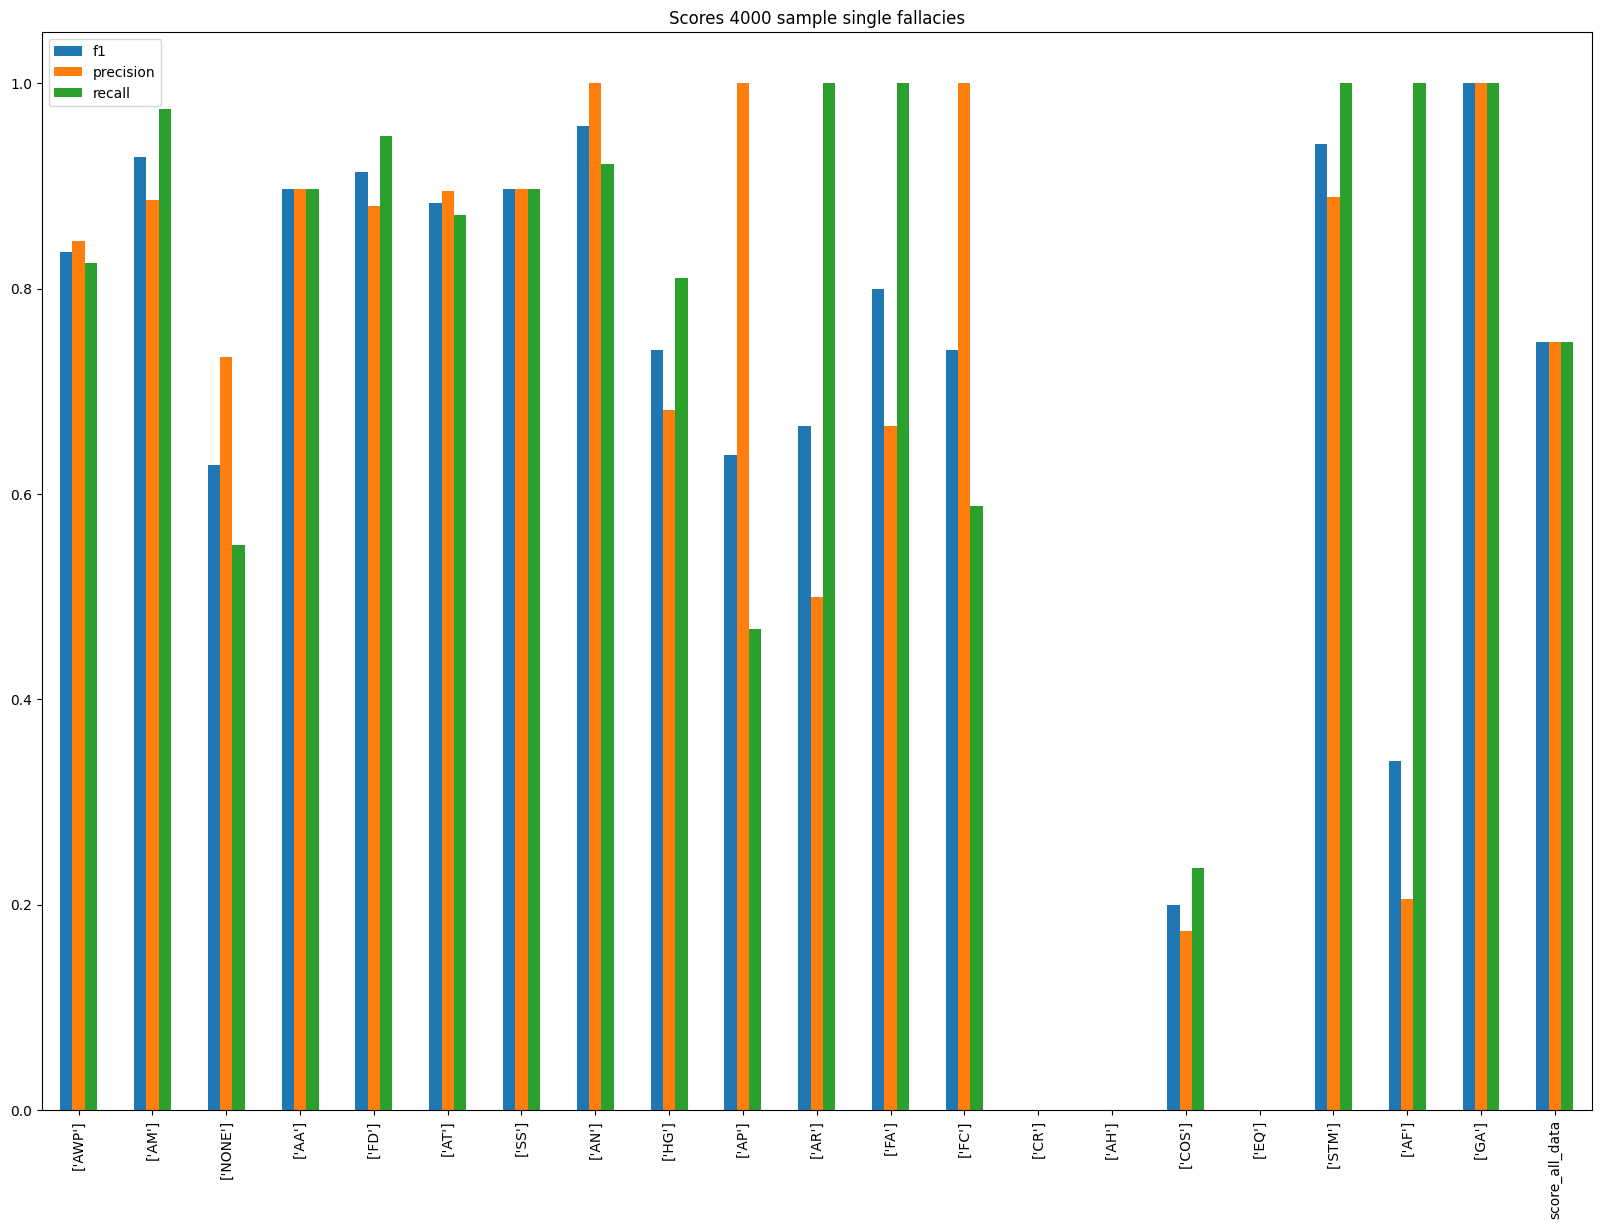

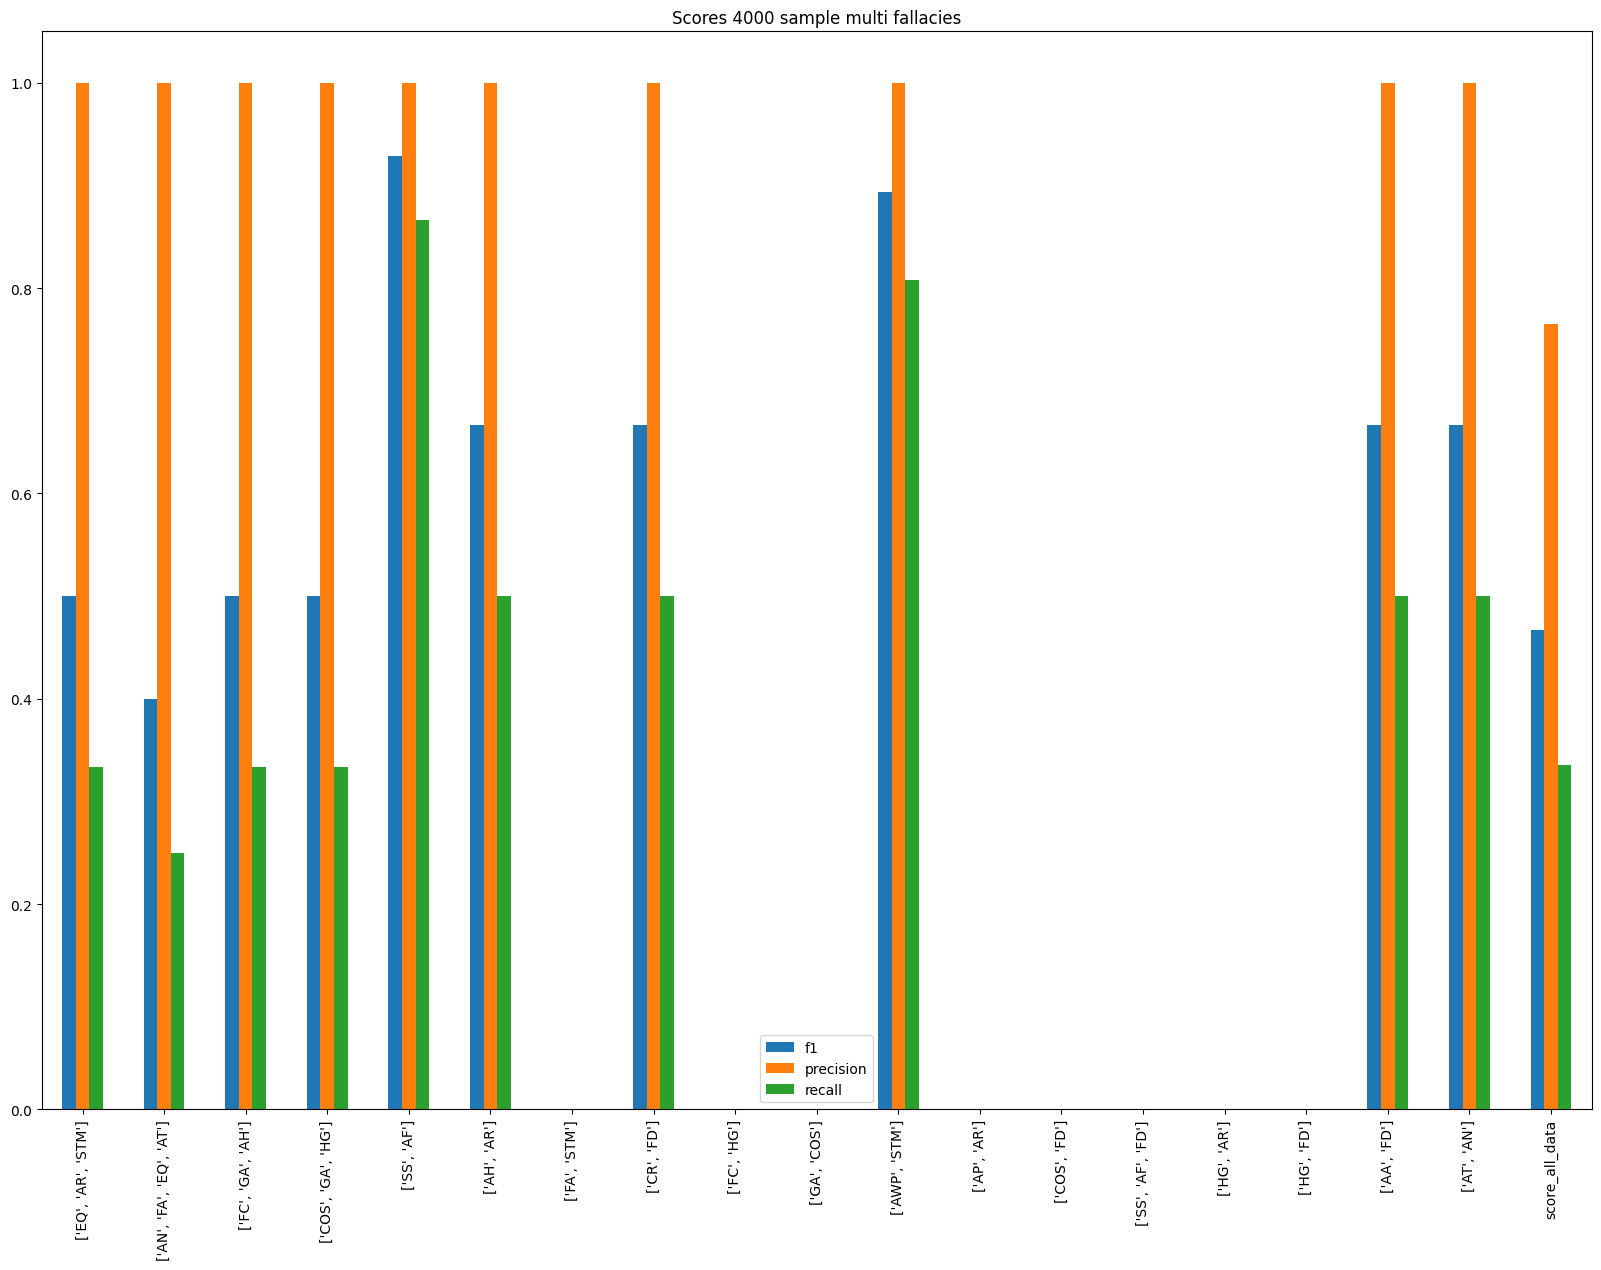

In [13]:
plot_metric(
    metric=metric_single,
    title=f'Scores {n_sample} sample single fallacies',
    file_plot=file_plot_single,
    file_metric=file_metric_single
)
plot_metric(
    metric=metric_multi,
    title=f'Scores {n_sample} sample multi fallacies',
    file_plot=file_plot_multi,
    file_metric=file_metric_multi
)